In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 4.1. Loading data with linear interpolation.

In [2]:
# Open df with FL characteristics (y)

df = pd.read_csv("FL_augm_inter_w_smooth.csv", index_col = 'idx').iloc[:,1:] #"FL_augm_inter_w.csv"
df

,I,x,y,left_bound,right_bound,down_bound,up_bound,I_x_left,I_x_right,I_y_down,I_y_up,Cu,Ni,Pb,Al,Co,Cr,NO3
idx,,,,,,,,,,,,,,,,,,
1,1094.013,440.0,350.0,410.997078,483.985513,319.837088,377.141444,32092.946811,55681.420983,7526.354879,6554.217700,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,202.294,450.0,350.0,414.577059,498.744699,323.395276,380.964878,6988.960165,10871.964268,1184.090837,1342.087958,0.0,0.0,0.0,0.0,4.5,4.5,22.5
100,177.025,454.0,355.0,417.197886,502.827048,327.105424,383.454723,6662.354552,9932.300708,1123.217310,1146.207041,0.0,0.0,1.5,3.0,6.0,4.5,37.5
1000,191.846,455.0,355.0,418.799921,504.925887,327.328667,383.479384,6944.652646,10680.836195,1170.757224,1225.503524,0.0,4.5,0.0,6.0,6.0,4.5,52.5
1001,631.573,441.0,350.0,411.644120,485.927998,321.419781,377.998183,18644.724966,32540.515302,4147.462148,3894.747976,0.0,4.5,1.5,0.0,0.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,246.346,456.0,355.0,418.914238,505.600813,327.041189,383.432359,9085.038092,13701.728784,1521.052042,1555.695514,0.0,4.5,0.0,6.0,3.0,4.5,46.5
996,399.123,456.0,360.0,422.002086,505.372822,328.436916,390.751460,13991.087131,22430.024973,2782.018995,2715.377589,0.0,4.5,0.0,6.0,4.5,0.0,36.0
997,256.685,454.0,355.0,417.657632,504.495323,326.466136,383.546410,9514.945313,14770.350457,1663.446831,1668.043184,0.0,4.5,0.0,6.0,4.5,3.0,45.0


In [3]:
idx_norm = 1

df_norm = pd.DataFrame()

df_norm['I'] = df['I'] / df['I'].loc[idx_norm]
df_norm['x'] = df['x'] / df['x'].loc[idx_norm]
df_norm['y'] = df['y'] / df['y'].loc[idx_norm]

df_norm['x_hw_mean'] = (df['right_bound'] + df['left_bound']) / (df['right_bound'].loc[idx_norm] + df['left_bound'].loc[idx_norm])
df_norm['x_hw_res'] = (df['right_bound'] - df['left_bound']) / (df['right_bound'].loc[idx_norm] - df['left_bound'].loc[idx_norm])
df_norm['y_hw_mean'] = (df['up_bound'] + df['down_bound']) / (df['up_bound'].loc[idx_norm] + df['down_bound'].loc[idx_norm])
df_norm['y_hw_res'] = (df['up_bound'] - df['down_bound']) / (df['up_bound'].loc[idx_norm] - df['down_bound'].loc[idx_norm])

df_norm['x_I_mean'] = (df['I_x_right'] + df['I_x_left']) / (df['I_x_right'].loc[idx_norm] + df['I_x_left'].loc[idx_norm])
df_norm['x_I_res'] = (df['I_x_right'] - df['I_x_left']) / (df['I_x_right'].loc[idx_norm] - df['I_x_left'].loc[idx_norm])
df_norm['y_I_mean'] = (df['I_y_up'] + df['I_y_down']) / (df['I_y_up'].loc[idx_norm] + df['I_y_down'].loc[idx_norm])
df_norm['y_I_res'] = (df['I_y_up'] - df['I_y_down']) / (df['I_y_up'].loc[idx_norm] - df['I_y_down'].loc[idx_norm])

df_norm['Cu'] = df['Cu']
df_norm['Ni'] = df['Ni']
df_norm['Pb'] = df['Pb']
df_norm['Al'] = df['Al']
df_norm['Co'] = df['Co']
df_norm['Cr'] = df['Cr']
df_norm['NO3'] = df['NO3']

df_norm

,I,x,y,x_hw_mean,x_hw_res,y_hw_mean,y_hw_res,x_I_mean,x_I_res,y_I_mean,y_I_res,Cu,Ni,Pb,Al,Co,Cr,NO3
idx,,,,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.184910,1.022727,1.000000,1.020491,1.153164,1.010591,1.004629,0.203487,0.164614,0.179409,-0.162526,0.0,0.0,0.0,0.0,4.5,4.5,22.5
100,0.161813,1.031818,1.014286,1.027981,1.173188,1.019486,0.983334,0.189060,0.138625,0.161174,-0.023649,0.0,0.0,1.5,3.0,6.0,4.5,37.5
1000,0.175360,1.034091,1.014286,1.032116,1.179995,1.019842,0.979868,0.200805,0.158390,0.170182,-0.056315,0.0,4.5,0.0,6.0,6.0,4.5,52.5
1001,0.577299,1.002273,1.000000,1.002893,1.017749,1.003500,0.987332,0.583146,0.589092,0.571156,0.259957,0.0,4.5,1.5,0.0,0.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.225176,1.036364,1.014286,1.032998,1.187675,1.019362,0.984064,0.259606,0.195718,0.218510,-0.035636,0.0,4.5,0.0,6.0,3.0,4.5,46.5
996,0.364825,1.036364,1.028571,1.036193,1.142246,1.031866,1.087431,0.414940,0.357757,0.390424,0.068551,0.0,4.5,0.0,6.0,4.5,0.0,36.0
997,0.234627,1.031818,1.014286,1.030359,1.189746,1.018701,0.996090,0.276679,0.222795,0.236602,-0.004728,0.0,4.5,0.0,6.0,4.5,3.0,45.0


# Building models

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2_score


def rmse(y_true, y_pred, kwargs={}):
    return (mse(y_true, y_pred, **kwargs))**0.5

def scatter_prediction(model, 
                       x, 
                       y_true, 
                       title = ""):
    """Evaluates MSE and R^2 of model. 
    Draws scatter plot of (y_true, y_predicted).
    Returns  (mse, r2)
    """
    y_pred = model.predict(x)
    model_rmse = rmse(y_true, y_pred)
    model_mae = mae(y_true, y_pred)
    model_r2 = r2_score(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(y_true, y_pred, 'o', markersize=2, alpha = 0.2) 
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], markersize=2, alpha = 0.5, color='r') 
    ax.set_title(f"RMSE={round(model_rmse, 5)} | MAE={round(model_mae, 5)} | R2={round(model_r2, 5)} | {title}")
    ax.set_xlabel("y_true")
    ax.set_ylabel("y_pred")
    plt.show()
    
    return model_rmse, model_mae, model_r2

In [5]:
l_PR_ION = ['Cu', 'Ni', 'Pb', 'Al', 'Co', 'Cr', 'NO3']

x = df_norm.drop(l_PR_ION, axis=1).to_numpy()
#y = df_norm[l_PR_ION[0]].to_numpy()

x.shape #, y.shape

(7813, 11)

## 5. Scaling y-data
Train / Validation / Test = 0.7 / 0.2 / 0.1

TRAIN_TEST_RATIO = (Test) / (Train+Validation+Test)

VALIDATION_TRAIN_RATIO = Validation / (Train+Validation)

In [6]:
TEST_TRAIN_RATIO = 0.1
n_splits = 10
VALIDATION_TRAIN_RATIO = 2 / 9 #7 / 9
RS = None

N_ITER_NO_CHANGE = 20

In [7]:
scaler_y = MinMaxScaler()
scaler_x = StandardScaler()

## 6. Model - MLP
Ordinary one-hidden-layer with *HIDDEN_LAYER_SIZES*=64 neurons perceptron.
We use MLPRegressor from scikit-learn library.

In [8]:
mlp_HIDDEN_LAYER_SIZES = [64]
mlp_ACTIVATION = 'tanh'
mlp_SOLVER = 'adam'
mlp_MAX_ITER = 10000
TOL = 1e-3

In [12]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, make_scorer

from tqdm import tqdm

n_splits = 10
scoring = {'rmse': make_scorer(root_mean_squared_error), 
           'mae': make_scorer(mean_absolute_error),
           'r2': make_scorer(r2_score)}

l_PR_ION = ['Cu', 'Ni', 'Pb', 'Al', 'Co', 'Cr', 'NO3']

mlp_mean_rmse, mlp_std_rmse = [], []
mlp_mean_mae, mlp_std_mae = [], []
mlp_mean_r2, mlp_std_r2 = [], []


for PR_ION in tqdm(l_PR_ION):
    model = MLPRegressor(hidden_layer_sizes=mlp_HIDDEN_LAYER_SIZES,
                         activation=mlp_ACTIVATION,
                         solver=mlp_SOLVER,
                         early_stopping=True,
                         validation_fraction=VALIDATION_TRAIN_RATIO,
                         n_iter_no_change=N_ITER_NO_CHANGE,
                         learning_rate_init = 0.001,
                         learning_rate='constant',
                         max_iter=mlp_MAX_ITER,
                         random_state=RS,
                         tol=TOL)
    mlp_pipel = Pipeline([('scale', scaler_x), ('mlp', model)])
    
    # Choosing certain ion 
    y = df_norm[[PR_ION]].to_numpy()
    # Scaling y before train_test split in cv only because we aprior know the distribution of ions.
    scaler_y = MinMaxScaler()
    y_all_scaled = scaler_y.fit_transform(y)
    y_scaler_multiplier = scaler_y.data_max_[0] - scaler_y.data_min_[0]
    
    cv_rf_kf = cross_validate(mlp_pipel, x, y_all_scaled.ravel(), cv=KFold(shuffle=True, n_splits=n_splits), scoring=scoring)
    
    mlp_mean_mae.append(np.mean(cv_rf_kf['test_mae']) * y_scaler_multiplier)
    mlp_std_mae.append(np.std(cv_rf_kf['test_mae']) * y_scaler_multiplier)
    
    mlp_mean_rmse.append(np.mean(cv_rf_kf['test_rmse']) * y_scaler_multiplier)
    mlp_std_rmse.append(np.std(cv_rf_kf['test_rmse']) * y_scaler_multiplier)
    
    mlp_mean_r2.append(np.mean(cv_rf_kf['test_r2']))
    mlp_std_r2.append(np.std(cv_rf_kf['test_r2']))

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [02:26<00:00, 20.90s/it]


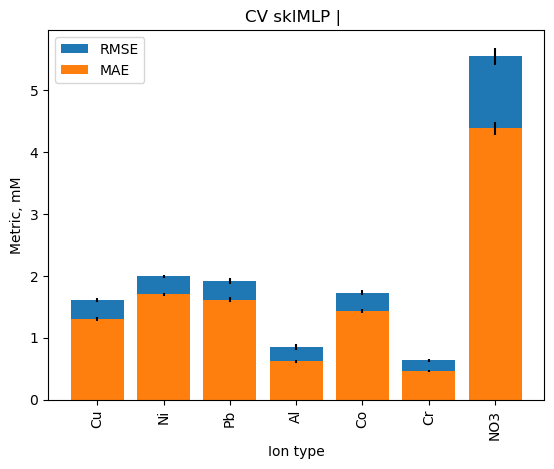

In [13]:
plt.bar(l_PR_ION, mlp_mean_rmse, 
             yerr=mlp_std_rmse) # , fmt='o-'
plt.bar(l_PR_ION, mlp_mean_mae, 
             yerr=mlp_std_mae) # , fmt='o-'


#plt.xscale('log')
#plt.yscale('log')
plt.xticks(rotation=90)
plt.xlabel('Ion type') #'number of params'
plt.ylabel('Metric, mM')
plt.legend(['RMSE', 'MAE'])
plt.title(f'CV sklMLP | ')

plt.savefig('Output_data/Multi_Exper_diff_m_mlp_1.png')

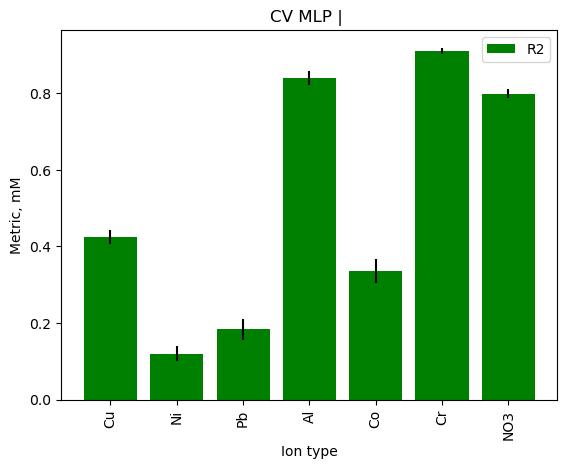

In [14]:
plt.bar(l_PR_ION, (mlp_mean_r2), 
             yerr=mlp_std_r2, color='g') # , fmt='o-'

#plt.xscale('log')
#plt.yscale('log')
plt.xticks(rotation=90)
plt.xlabel('Ion type') #'number of params'
plt.ylabel('Metric, mM')
plt.legend(['R2'])
plt.title(f'CV MLP | ')

plt.savefig('Output_data/Multi_Exper_diff_m_mlp_2.png')

In [15]:
dic = dict(cb_mean_rmse = mlp_mean_rmse,
cb_std_rmse = mlp_std_rmse,
cb_mean_mae = mlp_mean_mae,
cb_std_mae = mlp_std_mae,
cb_mean_r2 = mlp_mean_r2,
cb_std_r2 = mlp_std_r2,
)

df = pd.DataFrame(dic)
df.index = l_PR_ION
df.index.name = 'ion'
df

,cb_mean_rmse,cb_std_rmse,cb_mean_mae,cb_std_mae,cb_mean_r2,cb_std_r2
ion,,,,,,
Cu,1.607329,0.035859,1.294553,0.032240,0.424937,0.018455
Ni,1.988172,0.025409,1.700716,0.027798,0.119869,0.018773
Pb,1.916244,0.042899,1.610981,0.037548,0.183029,0.028345
Al,0.848521,0.043643,0.616618,0.026633,0.839095,0.018216
Co,1.727316,0.039251,1.431871,0.037887,0.335853,0.030511
Cr,0.634105,0.026299,0.469300,0.016541,0.910303,0.008241
NO3,5.544705,0.138195,4.383266,0.103638,0.798580,0.011992


In [16]:
df.to_csv('Output_data/Multi_Exper_diff_m_mlp.csv')
df.to_excel('Output_data/Multi_Exper_diff_m_mlp.xlsx')

# 7. Catboost

In [17]:
import catboost

In [18]:
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, make_scorer

from tqdm import tqdm

n_splits = 10
scoring = {'rmse': make_scorer(root_mean_squared_error), 
           'mae': make_scorer(mean_absolute_error),
           'r2': make_scorer(r2_score)}

l_PR_ION = ['Cu', 'Ni', 'Pb', 'Al', 'Co', 'Cr', 'NO3']

cb_mean_rmse, cb_std_rmse = [], []
cb_mean_mae, cb_std_mae = [], []
cb_mean_r2, cb_std_r2 = [], []


for PR_ION in tqdm(l_PR_ION):
    
    model = catboost.CatBoostRegressor(verbose=0, random_seed=RS)
    cb_pipel = Pipeline([('scale', scaler_x), ('cb', model)])
    
    # Choosing certain ion 
    y = df_norm[[PR_ION]].to_numpy()
    # Scaling y before train_test split in cv only because we aprior know the distribution of ions.
    scaler_y = MinMaxScaler()
    y_all_scaled = scaler_y.fit_transform(y)
    y_scaler_multiplier = scaler_y.data_max_[0] - scaler_y.data_min_[0]
    
    cv_rf_kf = cross_validate(cb_pipel, x, y_all_scaled.ravel(), cv=KFold(shuffle=True, n_splits=n_splits), scoring=scoring)
    
    cb_mean_mae.append(np.mean(cv_rf_kf['test_mae']) * y_scaler_multiplier)
    cb_std_mae.append(np.std(cv_rf_kf['test_mae']) * y_scaler_multiplier)
    
    cb_mean_rmse.append(np.mean(cv_rf_kf['test_rmse']) * y_scaler_multiplier)
    cb_std_rmse.append(np.std(cv_rf_kf['test_rmse']) * y_scaler_multiplier)
    
    cb_mean_r2.append(np.mean(cv_rf_kf['test_r2']))
    cb_std_r2.append(np.std(cv_rf_kf['test_r2']))

100%|██████████| 7/7 [04:57<00:00, 42.46s/it]


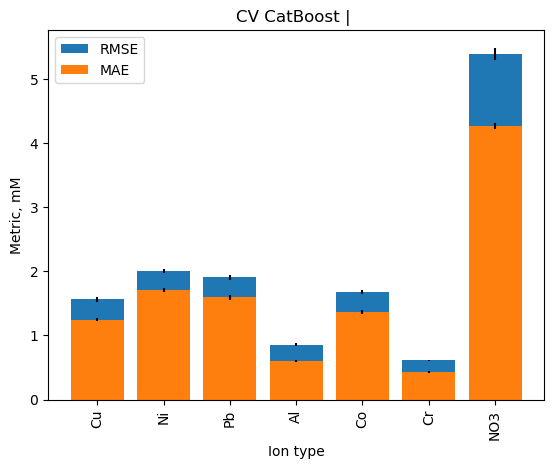

In [19]:
plt.bar(l_PR_ION, cb_mean_rmse, 
             yerr=cb_std_rmse) # , fmt='o-'
plt.bar(l_PR_ION, cb_mean_mae, 
             yerr=cb_std_mae) # , fmt='o-'

#plt.xscale('log')
#plt.yscale('log')
plt.xticks(rotation=90)
plt.xlabel('Ion type') #'number of params'
plt.ylabel('Metric, mM')
plt.legend(['RMSE', 'MAE'])
plt.title(f'CV CatBoost | ')

plt.savefig('Output_data/Multi_Exper_diff_m_cb_1.png')

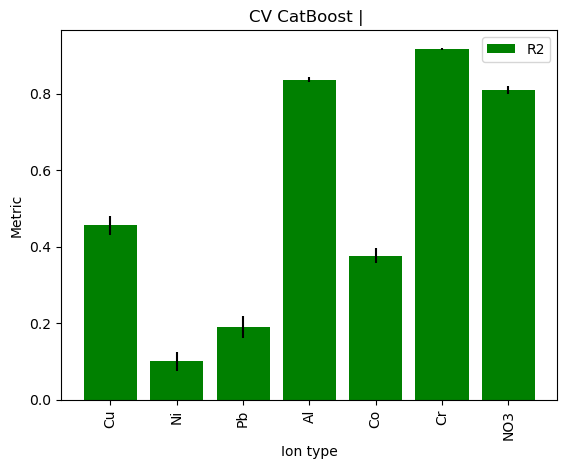

In [20]:
plt.bar(l_PR_ION, cb_mean_r2, 
             yerr=cb_std_r2, color='g') # , fmt='o-'

#plt.xscale('log')
#plt.yscale('log')
plt.xticks(rotation=90)
plt.xlabel('Ion type') #'number of params'
plt.ylabel('Metric')
plt.legend(['R2'])
plt.title(f'CV CatBoost | ')

plt.savefig('Output_data/Multi_Exper_diff_m_cb_2.png')

In [21]:
dic = dict(cb_mean_rmse = cb_mean_rmse,
cb_std_rmse = cb_std_rmse,
cb_mean_mae = cb_mean_mae,
cb_std_mae = cb_std_mae,
cb_mean_r2 = cb_mean_r2,
cb_std_r2 = cb_std_r2,
)

df = pd.DataFrame(dic)
df.index = l_PR_ION
df.index.name = 'ion'
df

,cb_mean_rmse,cb_std_rmse,cb_mean_mae,cb_std_mae,cb_mean_r2,cb_std_r2
ion,,,,,,
Cu,1.563488,0.037424,1.243692,0.025026,0.455670,0.025351
Ni,2.010975,0.030193,1.711031,0.029098,0.100197,0.025298
Pb,1.908046,0.041311,1.592016,0.032530,0.189471,0.028091
Al,0.858601,0.023585,0.597748,0.018519,0.835955,0.006802
Co,1.675312,0.030123,1.368795,0.031942,0.375581,0.019688
Cr,0.611419,0.011794,0.428523,0.013627,0.916834,0.003376
NO3,5.393547,0.094143,4.266689,0.047407,0.809527,0.010173


In [22]:
df.to_csv('Output_data/Multi_Exper_diff_m_cb.csv')
df.to_excel('Output_data/Multi_Exper_diff_m_cb.xlsx')

## 8. Model - KAN


In [38]:
import torch
from kan import KAN

from tools import kfold_experiment_es

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


checkpoint directory created: ./model
saving model version 0.0
kfold: 0


trn_ls: 2.55e-01 | vl_ls: 2.76e-01 | e_stop: 20/20 | tst_ls: 2.76e-01 | reg: 3.82e+01 :  19%|▊   | 38/200 [02:26<10:24,  3.86s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 1


trn_ls: 2.56e-01 | vl_ls: 2.61e-01 | e_stop: 20/20 | tst_ls: 2.61e-01 | reg: 3.54e+01 :  20%|▊   | 41/200 [02:37<10:09,  3.83s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 2


trn_ls: 2.56e-01 | vl_ls: 2.58e-01 | e_stop: 20/20 | tst_ls: 2.58e-01 | reg: 3.40e+01 :  14%|▌   | 29/200 [01:54<11:12,  3.94s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 3


trn_ls: 2.56e-01 | vl_ls: 2.68e-01 | e_stop: 20/20 | tst_ls: 2.68e-01 | reg: 3.03e+01 :  14%|▌   | 28/200 [02:18<14:12,  4.96s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 4


trn_ls: 2.57e-01 | vl_ls: 2.69e-01 | e_stop: 20/20 | tst_ls: 2.69e-01 | reg: 3.11e+01 :  14%|▌   | 28/200 [02:51<17:35,  6.14s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 5


trn_ls: 2.55e-01 | vl_ls: 2.55e-01 | e_stop: 20/20 | tst_ls: 2.55e-01 | reg: 3.38e+01 :  24%|▉   | 47/200 [04:49<15:43,  6.17s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 6


trn_ls: 2.56e-01 | vl_ls: 2.60e-01 | e_stop: 20/20 | tst_ls: 2.60e-01 | reg: 3.94e+01 :  21%|▊   | 42/200 [03:39<13:46,  5.23s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 7


trn_ls: 2.59e-01 | vl_ls: 2.90e-01 | e_stop: 20/20 | tst_ls: 2.90e-01 | reg: 3.43e+01 :  15%|▌   | 30/200 [02:29<14:08,  4.99s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 8


trn_ls: 2.57e-01 | vl_ls: 2.99e-01 | e_stop: 20/20 | tst_ls: 2.99e-01 | reg: 3.36e+01 :  18%|▋   | 36/200 [02:55<13:20,  4.88s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 9


trn_ls: 2.53e-01 | vl_ls: 2.71e-01 | e_stop: 20/20 | tst_ls: 2.71e-01 | reg: 3.78e+01 :  24%|▉   | 49/200 [03:49<11:45,  4.68s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 0


trn_ls: 3.18e-01 | vl_ls: 3.67e-01 | e_stop: 20/20 | tst_ls: 3.67e-01 | reg: 2.93e+01 :  10%|▍   | 20/200 [01:34<14:12,  4.74s/it]

Early stopping criteria raised


checkpoint directory created: ./model
saving model version 0.0
kfold: 1


trn_ls: 3.15e-01 | vl_ls: 3.25e-01 | e_stop: 20/20 | tst_ls: 3.25e-01 | reg: 3.83e+01 :  24%|▉   | 49/200 [03:57<12:12,  4.85s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 2


trn_ls: 3.16e-01 | vl_ls: 3.19e-01 | e_stop: 20/20 | tst_ls: 3.19e-01 | reg: 3.06e+01 :  21%|▊   | 42/200 [03:27<12:59,  4.93s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 3


trn_ls: 3.16e-01 | vl_ls: 3.41e-01 | e_stop: 20/20 | tst_ls: 3.41e-01 | reg: 3.31e+01 :  18%|▋   | 35/200 [03:11<15:01,  5.47s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 4


trn_ls: 3.16e-01 | vl_ls: 3.26e-01 | e_stop: 20/20 | tst_ls: 3.26e-01 | reg: 3.18e+01 :  17%|▋   | 34/200 [03:01<14:47,  5.35s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 5


trn_ls: 3.17e-01 | vl_ls: 3.20e-01 | e_stop: 20/20 | tst_ls: 3.20e-01 | reg: 3.14e+01 :  16%|▋   | 32/200 [02:19<12:12,  4.36s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 6


trn_ls: 3.20e-01 | vl_ls: 8.27e-01 | e_stop: 20/20 | tst_ls: 8.27e-01 | reg: 3.26e+01 :  18%|▋   | 35/200 [02:30<11:50,  4.30s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 7


trn_ls: 3.16e-01 | vl_ls: 3.30e-01 | e_stop: 20/20 | tst_ls: 3.30e-01 | reg: 3.73e+01 :  18%|▋   | 35/200 [02:30<11:49,  4.30s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 8


trn_ls: 3.18e-01 | vl_ls: 3.58e-01 | e_stop: 20/20 | tst_ls: 3.58e-01 | reg: 3.16e+01 :  12%|▍   | 23/200 [01:43<13:19,  4.52s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 9


trn_ls: 3.17e-01 | vl_ls: 3.30e-01 | e_stop: 20/20 | tst_ls: 3.30e-01 | reg: 3.40e+01 :  17%|▋   | 34/200 [02:25<11:48,  4.27s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 0


trn_ls: 3.07e-01 | vl_ls: 3.25e-01 | e_stop: 20/20 | tst_ls: 3.25e-01 | reg: 3.09e+01 :  11%|▍   | 22/200 [01:48<14:36,  4.93s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 1


trn_ls: 3.07e-01 | vl_ls: 3.18e-01 | e_stop: 20/20 | tst_ls: 3.18e-01 | reg: 2.99e+01 :  12%|▍   | 24/200 [01:54<13:56,  4.75s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 2


trn_ls: 3.07e-01 | vl_ls: 3.18e-01 | e_stop: 20/20 | tst_ls: 3.18e-01 | reg: 3.06e+01 :  12%|▌   | 25/200 [01:49<12:47,  4.38s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 3


trn_ls: 3.07e-01 | vl_ls: 3.27e-01 | e_stop: 20/20 | tst_ls: 3.27e-01 | reg: 3.18e+01 :  11%|▍   | 22/200 [01:40<13:33,  4.57s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 4


trn_ls: 3.08e-01 | vl_ls: 3.09e-01 | e_stop: 20/20 | tst_ls: 3.09e-01 | reg: 3.15e+01 :  12%|▍   | 23/200 [01:44<13:24,  4.55s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 5


trn_ls: 3.09e-01 | vl_ls: 3.11e-01 | e_stop: 20/20 | tst_ls: 3.11e-01 | reg: 3.17e+01 :  13%|▌   | 26/200 [01:53<12:38,  4.36s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 6


trn_ls: 3.07e-01 | vl_ls: 3.15e-01 | e_stop: 20/20 | tst_ls: 3.15e-01 | reg: 3.17e+01 :  12%|▍   | 23/200 [01:41<12:58,  4.40s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 7


trn_ls: 3.08e-01 | vl_ls: 3.14e-01 | e_stop: 20/20 | tst_ls: 3.14e-01 | reg: 3.02e+01 :  10%|▍   | 21/200 [01:38<13:57,  4.68s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 8


trn_ls: 3.07e-01 | vl_ls: 3.18e-01 | e_stop: 20/20 | tst_ls: 3.18e-01 | reg: 3.74e+01 :  15%|▌   | 30/200 [02:09<12:11,  4.30s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 9


trn_ls: 3.07e-01 | vl_ls: 3.26e-01 | e_stop: 20/20 | tst_ls: 3.26e-01 | reg: 3.38e+01 :  11%|▍   | 22/200 [01:41<13:42,  4.62s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 0


trn_ls: 1.34e-01 | vl_ls: 1.44e-01 | e_stop: 20/20 | tst_ls: 1.44e-01 | reg: 3.09e+01 :  14%|▌   | 29/200 [02:06<12:26,  4.36s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 1


trn_ls: 1.34e-01 | vl_ls: 1.31e-01 | e_stop: 20/20 | tst_ls: 1.31e-01 | reg: 3.09e+01 :  14%|▌   | 29/200 [02:04<12:13,  4.29s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 2


trn_ls: 1.36e-01 | vl_ls: 1.36e-01 | e_stop: 20/20 | tst_ls: 1.36e-01 | reg: 2.83e+01 :  14%|▌   | 27/200 [02:00<12:52,  4.47s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 3


trn_ls: 1.35e-01 | vl_ls: 1.41e-01 | e_stop: 20/20 | tst_ls: 1.41e-01 | reg: 2.90e+01 :  12%|▍   | 24/200 [01:47<13:10,  4.49s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 4


trn_ls: 1.35e-01 | vl_ls: 1.33e-01 | e_stop: 20/20 | tst_ls: 1.33e-01 | reg: 2.83e+01 :  14%|▌   | 27/200 [01:59<12:47,  4.44s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 5


trn_ls: 1.33e-01 | vl_ls: 1.36e-01 | e_stop: 20/20 | tst_ls: 1.36e-01 | reg: 2.92e+01 :  16%|▋   | 33/200 [02:22<12:02,  4.33s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 6


trn_ls: 1.35e-01 | vl_ls: 1.57e-01 | e_stop: 20/20 | tst_ls: 1.57e-01 | reg: 2.70e+01 :  12%|▌   | 25/200 [01:47<12:31,  4.30s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 7


trn_ls: 1.34e-01 | vl_ls: 1.42e-01 | e_stop: 20/20 | tst_ls: 1.42e-01 | reg: 2.84e+01 :  14%|▌   | 27/200 [01:57<12:31,  4.35s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 8


trn_ls: 1.34e-01 | vl_ls: 1.39e-01 | e_stop: 20/20 | tst_ls: 1.39e-01 | reg: 2.87e+01 :  14%|▌   | 28/200 [02:04<12:43,  4.44s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 9


trn_ls: 1.34e-01 | vl_ls: 1.39e-01 | e_stop: 20/20 | tst_ls: 1.39e-01 | reg: 2.92e+01 :  20%|▊   | 39/200 [02:51<11:49,  4.41s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 0


trn_ls: 2.79e-01 | vl_ls: 3.10e-01 | e_stop: 20/20 | tst_ls: 3.10e-01 | reg: 3.25e+01 :  11%|▍   | 22/200 [01:39<13:26,  4.53s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 1


trn_ls: 2.77e-01 | vl_ls: 2.76e-01 | e_stop: 20/20 | tst_ls: 2.76e-01 | reg: 3.45e+01 :  18%|▋   | 37/200 [02:45<12:09,  4.47s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 2


trn_ls: 2.78e-01 | vl_ls: 2.79e-01 | e_stop: 20/20 | tst_ls: 2.79e-01 | reg: 3.40e+01 :  14%|▌   | 27/200 [02:00<12:53,  4.47s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 3


trn_ls: 2.75e-01 | vl_ls: 2.72e-01 | e_stop: 20/20 | tst_ls: 2.72e-01 | reg: 4.10e+01 :  23%|▉   | 46/200 [03:22<11:17,  4.40s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 4


trn_ls: 2.76e-01 | vl_ls: 2.83e-01 | e_stop: 20/20 | tst_ls: 2.83e-01 | reg: 3.17e+01 :  18%|▋   | 36/200 [02:36<11:51,  4.34s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 5


trn_ls: 2.76e-01 | vl_ls: 2.97e-01 | e_stop: 20/20 | tst_ls: 2.97e-01 | reg: 3.39e+01 :  16%|▌   | 31/200 [02:15<12:20,  4.38s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 6


trn_ls: 2.77e-01 | vl_ls: 2.88e-01 | e_stop: 20/20 | tst_ls: 2.88e-01 | reg: 3.43e+01 :  12%|▍   | 24/200 [01:46<13:01,  4.44s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 7


trn_ls: 2.75e-01 | vl_ls: 2.91e-01 | e_stop: 20/20 | tst_ls: 2.91e-01 | reg: 3.71e+01 :  18%|▋   | 36/200 [02:36<11:53,  4.35s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 8


trn_ls: 2.76e-01 | vl_ls: 2.83e-01 | e_stop: 20/20 | tst_ls: 2.83e-01 | reg: 3.98e+01 :  24%|▉   | 47/200 [03:32<11:33,  4.53s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 9


trn_ls: 2.75e-01 | vl_ls: 2.80e-01 | e_stop: 20/20 | tst_ls: 2.80e-01 | reg: 3.55e+01 :  22%|▊   | 43/200 [03:07<11:25,  4.37s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 0


trn_ls: 9.55e-02 | vl_ls: 9.46e-02 | e_stop: 20/20 | tst_ls: 9.46e-02 | reg: 3.42e+01 :  17%|▋   | 34/200 [02:28<12:05,  4.37s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 1


trn_ls: 9.62e-02 | vl_ls: 9.57e-02 | e_stop: 20/20 | tst_ls: 9.57e-02 | reg: 2.95e+01 :  14%|▌   | 27/200 [01:57<12:35,  4.37s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 2


trn_ls: 9.66e-02 | vl_ls: 1.02e-01 | e_stop: 20/20 | tst_ls: 1.02e-01 | reg: 3.34e+01 :  13%|▌   | 26/200 [01:58<13:15,  4.57s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 3


trn_ls: 9.54e-02 | vl_ls: 9.73e-02 | e_stop: 20/20 | tst_ls: 9.73e-02 | reg: 2.99e+01 :  15%|▌   | 30/200 [02:20<13:15,  4.68s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 4


trn_ls: 9.61e-02 | vl_ls: 9.88e-02 | e_stop: 20/20 | tst_ls: 9.88e-02 | reg: 2.71e+01 :  12%|▍   | 23/200 [01:44<13:27,  4.56s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 5


trn_ls: 9.52e-02 | vl_ls: 9.37e-02 | e_stop: 20/20 | tst_ls: 9.37e-02 | reg: 3.56e+01 :  16%|▌   | 31/200 [02:13<12:06,  4.30s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 6


trn_ls: 9.51e-02 | vl_ls: 9.98e-02 | e_stop: 20/20 | tst_ls: 9.98e-02 | reg: 3.21e+01 :  13%|▌   | 26/200 [01:54<12:45,  4.40s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 7


trn_ls: 9.40e-02 | vl_ls: 1.08e-01 | e_stop: 20/20 | tst_ls: 1.08e-01 | reg: 3.57e+01 :  16%|▋   | 32/200 [02:18<12:04,  4.31s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 8


trn_ls: 9.75e-02 | vl_ls: 9.62e-02 | e_stop: 20/20 | tst_ls: 9.62e-02 | reg: 2.93e+01 :  12%|▍   | 24/200 [01:49<13:19,  4.55s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 9


trn_ls: 9.59e-02 | vl_ls: 9.78e-02 | e_stop: 20/20 | tst_ls: 9.78e-02 | reg: 3.35e+01 :  14%|▌   | 27/200 [02:03<13:12,  4.58s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 0


trn_ls: 6.24e-02 | vl_ls: 6.61e-02 | e_stop: 20/20 | tst_ls: 6.61e-02 | reg: 2.67e+01 :  11%|▍   | 22/200 [01:37<13:06,  4.42s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 1


trn_ls: 6.25e-02 | vl_ls: 6.41e-02 | e_stop: 20/20 | tst_ls: 6.41e-02 | reg: 2.64e+01 :  10%|▍   | 21/200 [01:31<13:04,  4.38s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 2


trn_ls: 6.29e-02 | vl_ls: 6.33e-02 | e_stop: 20/20 | tst_ls: 6.33e-02 | reg: 2.85e+01 :  10%|▍   | 21/200 [01:39<14:10,  4.75s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 3


trn_ls: 6.22e-02 | vl_ls: 6.11e-02 | e_stop: 20/20 | tst_ls: 6.11e-02 | reg: 2.69e+01 :  12%|▍   | 23/200 [01:40<12:50,  4.35s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 4


trn_ls: 6.30e-02 | vl_ls: 6.44e-02 | e_stop: 20/20 | tst_ls: 6.44e-02 | reg: 2.92e+01 :  11%|▍   | 22/200 [01:38<13:19,  4.49s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 5


trn_ls: 6.21e-02 | vl_ls: 6.36e-02 | e_stop: 20/20 | tst_ls: 6.36e-02 | reg: 2.97e+01 :  12%|▌   | 25/200 [01:53<13:12,  4.53s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 6


trn_ls: 6.25e-02 | vl_ls: 6.53e-02 | e_stop: 20/20 | tst_ls: 6.53e-02 | reg: 2.66e+01 :  10%|▍   | 21/200 [01:38<14:02,  4.71s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 7


trn_ls: 6.23e-02 | vl_ls: 6.06e-02 | e_stop: 20/20 | tst_ls: 6.06e-02 | reg: 2.75e+01 :  11%|▍   | 22/200 [01:37<13:05,  4.41s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 8


trn_ls: 6.25e-02 | vl_ls: 6.74e-02 | e_stop: 20/20 | tst_ls: 6.74e-02 | reg: 2.77e+01 :  10%|▍   | 21/200 [01:32<13:07,  4.40s/it]


Early stopping criteria raised
checkpoint directory created: ./model
saving model version 0.0
kfold: 9


trn_ls: 6.05e-02 | vl_ls: 1.55e-01 | e_stop: 20/20 | tst_ls: 1.55e-01 | reg: 2.71e+01 :  20%|▊   | 40/200 [02:57<11:48,  4.43s/it]


Early stopping criteria raised


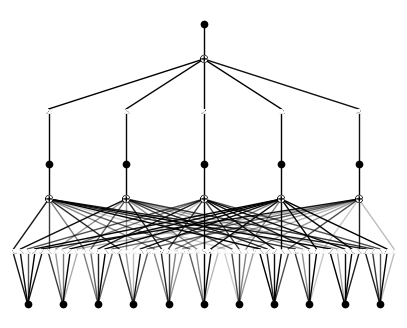

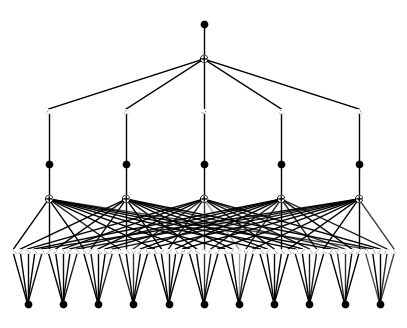

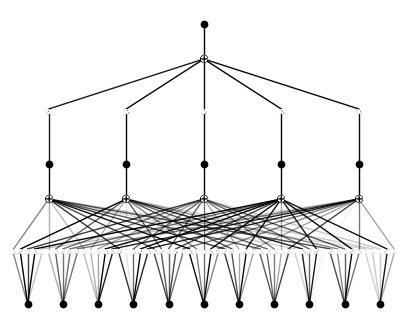

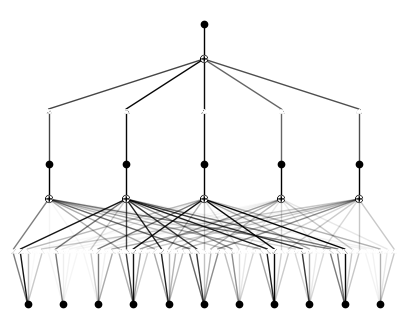

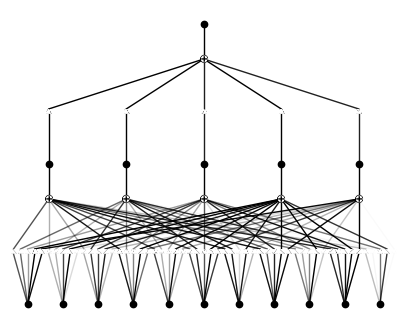

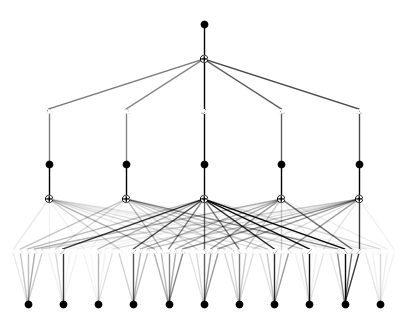

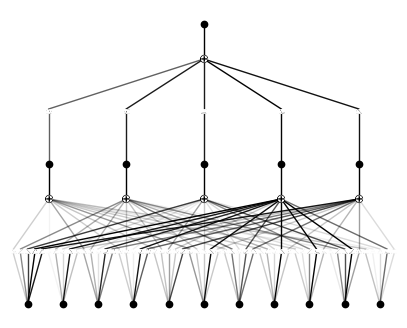

In [39]:
l_PR_ION = ['Cu', 'Ni', 'Pb', 'Al', 'Co', 'Cr', 'NO3']
input_shape = x.shape[1]

n_splits = 10


l_d_kan_params = [{'width':[input_shape,5,1], 'grid':3, 'k':3, 'device':device}] * len(l_PR_ION)
l_d_train_params = [{'tol': 1e-3, 'n_iter_no_change': 20,'opt': "LBFGS", 'steps': 200, 'lr': 1.0}] * len(l_PR_ION)
l_x = [x] * len(l_PR_ION)

l_y_scaled = []
l_y_scaler = []
for PR_ION in l_PR_ION:
    # Choosing certain ion 
    y = df_norm[[PR_ION]].to_numpy()
    # Scaling y before train_test split in cv only because we aprior know the distribution of ions.
    scaler_y = MinMaxScaler()
    y_all_scaled = scaler_y.fit_transform(y)
    l_y_scaler.append(scaler_y)
    l_y_scaled.append(y_all_scaled)
    
l_x_scaler=[scaler_x]*len(l_PR_ION)

kan_exper = kfold_experiment_es(l_x, l_y_scaled, l_d_kan_params, l_d_train_params, cv=n_splits, l_y_scaler=l_y_scaler, l_x_scaler=l_x_scaler)

In [40]:
kan_exper

(array([[1.58472653, 1.9789502 , 1.88912329, 0.83101601, 1.70234478,
         0.58906396, 5.3872621 ],
        [1.27150655, 1.66543899, 1.57909716, 0.59681161, 1.40274755,
         0.41741061, 4.23951674],
        [0.44075045, 0.12731583, 0.20599396, 0.84616421, 0.35508564,
         0.92261393, 0.80975271]]),
 array([[0.03816482, 0.08593966, 0.04214805, 0.02778705, 0.04431237,
         0.02341592, 0.1712964 ],
        [0.02859995, 0.04792073, 0.03355027, 0.02605746, 0.04618392,
         0.01235532, 0.14985702],
        [0.02313029, 0.05747856, 0.02538032, 0.01077417, 0.03314323,
         0.00661268, 0.0104821 ]]))

In [41]:
kan_mean_rmse, kan_std_rmse = kan_exper[0][0], kan_exper[1][0]
kan_mean_mae, kan_std_mae = kan_exper[0][1], kan_exper[1][1]
kan_mean_r2, kan_std_r2 = kan_exper[0][2], kan_exper[1][2]

In [42]:
kan_mean_rmse

array([1.58472653, 1.9789502 , 1.88912329, 0.83101601, 1.70234478,
       0.58906396, 5.3872621 ])

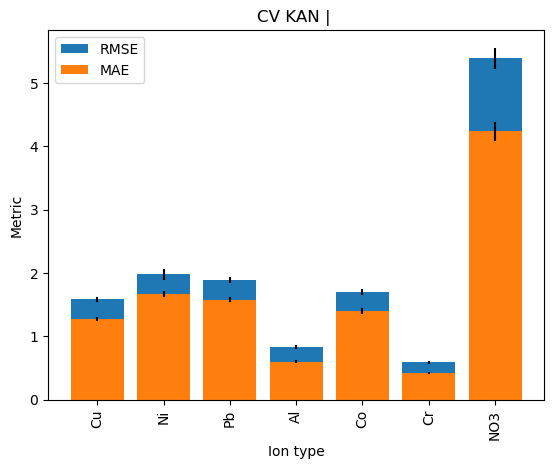

In [44]:
plt.bar(l_PR_ION, np.array(kan_mean_rmse), 
             yerr=np.array(kan_std_rmse)) # , fmt='o-'
plt.bar(l_PR_ION, np.array(kan_mean_mae), 
             yerr=np.array(kan_std_mae)) # , fmt='o-'

ax = plt.gca()
#ax.set_ylim([0, 20])
#plt.xscale('log')
#plt.yscale('log')
plt.xticks(rotation=90)
plt.xlabel('Ion type') #'number of params'
plt.ylabel('Metric')
plt.legend(['RMSE', 'MAE'])
plt.title(f'CV KAN | ')

plt.savefig('Output_data/Multi_Exper_diff_m_kan_1.png')

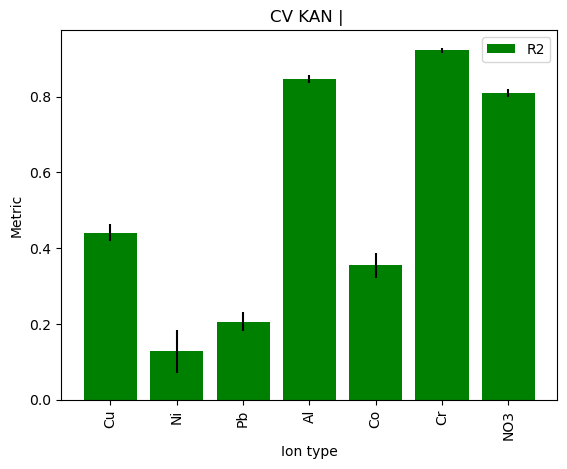

In [45]:
plt.bar(l_PR_ION, np.array(kan_mean_r2), 
             yerr=np.array(kan_std_r2), color='g') # , fmt='o-'

#plt.xscale('log')
#plt.yscale('log')
plt.xticks(rotation=90)
plt.xlabel('Ion type') #'number of params'
plt.ylabel('Metric')
plt.legend(['R2'])
plt.title(f'CV KAN | ')

plt.savefig('Output_data/Multi_Exper_diff_m_kan_2.png')

In [46]:
dic = dict(kan_mean_rmse = kan_mean_rmse,
kan_std_rmse = kan_std_rmse,
kan_mean_mae = kan_mean_mae,
kan_std_mae = kan_std_mae,
kan_mean_r2 = kan_mean_r2,
kan_std_r2 = kan_std_r2,
)

df = pd.DataFrame(dic)
df.index = l_PR_ION
df.index.name = 'ion'
df

,kan_mean_rmse,kan_std_rmse,kan_mean_mae,kan_std_mae,kan_mean_r2,kan_std_r2
ion,,,,,,
Cu,1.584727,0.038165,1.271507,0.028600,0.440750,0.023130
Ni,1.978950,0.085940,1.665439,0.047921,0.127316,0.057479
Pb,1.889123,0.042148,1.579097,0.033550,0.205994,0.025380
Al,0.831016,0.027787,0.596812,0.026057,0.846164,0.010774
Co,1.702345,0.044312,1.402748,0.046184,0.355086,0.033143
Cr,0.589064,0.023416,0.417411,0.012355,0.922614,0.006613
NO3,5.387262,0.171296,4.239517,0.149857,0.809753,0.010482


In [47]:
df.to_csv('Output_data/Multi_Exper_diff_m_kan.csv')
df.to_excel('Output_data/Multi_Exper_diff_m_kan.xlsx')

# 9. GMDH

In [9]:
from sklearn.base import BaseEstimator

def skl_regr_wrap(class_model, default_init_kwargs = {}, default_fit_kwargs = {}):
    '''
    Wrapper for regressor classes with fit, predict methods. Makes regressor compatable with skl cross-validation.
    Returns new class.
    '''
    class MyEstimator(BaseEstimator):
        '''
        Provides Sci-kit learn compatable Regressor class from class model with fit, predict functions 
        '''
        def __init__(self, *, init_kwargs=default_init_kwargs, fit_kwargs=default_fit_kwargs):
            self.init_kwargs = init_kwargs
            self.fit_kwargs = fit_kwargs
            self.class_model = class_model

        def fit(self, X, y=None):
            self.model = class_model(**self.init_kwargs)
            self.model.fit(X=X, y=y, **self.fit_kwargs)
            self.is_fitted_ = True
            return self

        def predict(self, X):
            return self.model.predict(X=X)
        
        
    return MyEstimator

In [39]:
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, make_scorer
from gmdh import Ria

from tqdm import tqdm

n_splits = 10
scoring = {'rmse': make_scorer(root_mean_squared_error), 
           'mae': make_scorer(mean_absolute_error),
           'r2': make_scorer(r2_score)}

l_PR_ION = ['Cu', 'Ni', 'Pb', 'Al', 'Co', 'Cr', 'NO3']

gmdh_mean_rmse, gmdh_std_rmse = [], []
gmdh_mean_mae, gmdh_std_mae = [], []
gmdh_mean_r2, gmdh_std_r2 = [], []


for PR_ION in tqdm(l_PR_ION):
    
    model = skl_regr_wrap(class_model=Ria)(fit_kwargs = dict(k_best=15, p_average=1))
    gmdh_pipel = Pipeline([('scale', scaler_x), ('cb', model)])
    
    # Choosing certain ion 
    y = df_norm[[PR_ION]].to_numpy()
    # Scaling y before train_test split in cv only because we aprior know the distribution of ions.
    scaler_y = MinMaxScaler()
    y_all_scaled = scaler_y.fit_transform(y)
    y_scaler_multiplier = scaler_y.data_max_[0] - scaler_y.data_min_[0]
    
    cv_gmdh_kf = cross_validate(gmdh_pipel, x, y_all_scaled.ravel(), cv=KFold(shuffle=True, n_splits=n_splits), scoring=scoring)
    
    gmdh_mean_mae.append(np.mean(cv_gmdh_kf['test_mae']) * y_scaler_multiplier)
    gmdh_std_mae.append(np.std(cv_gmdh_kf['test_mae']) * y_scaler_multiplier)
    
    gmdh_mean_rmse.append(np.mean(cv_gmdh_kf['test_rmse']) * y_scaler_multiplier)
    gmdh_std_rmse.append(np.std(cv_gmdh_kf['test_rmse']) * y_scaler_multiplier)
    
    gmdh_mean_r2.append(np.mean(cv_gmdh_kf['test_r2']))
    gmdh_std_r2.append(np.std(cv_gmdh_kf['test_r2']))

100%|██████████| 7/7 [01:28<00:00, 12.64s/it]


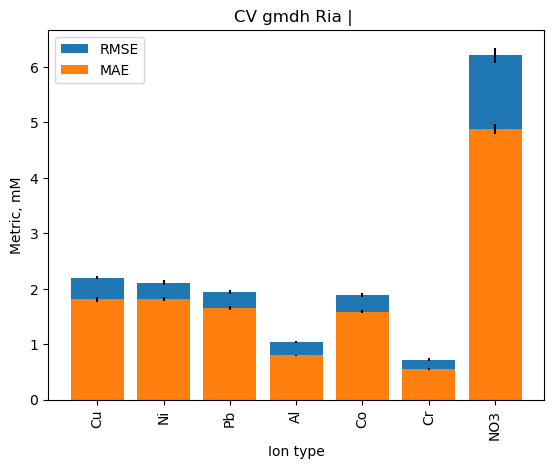

In [40]:
plt.bar(l_PR_ION, gmdh_mean_rmse, 
             yerr=gmdh_std_rmse) # , fmt='o-'
plt.bar(l_PR_ION, gmdh_mean_mae, 
             yerr=gmdh_std_mae) # , fmt='o-'

#plt.xscale('log')
#plt.yscale('log')
plt.xticks(rotation=90)
plt.xlabel('Ion type') #'number of params'
plt.ylabel('Metric, mM')
plt.legend(['RMSE', 'MAE'])
plt.title(f'CV gmdh Ria | ')

plt.savefig('Output_data/Multi_Exper_diff_m_gmdh_1.png')

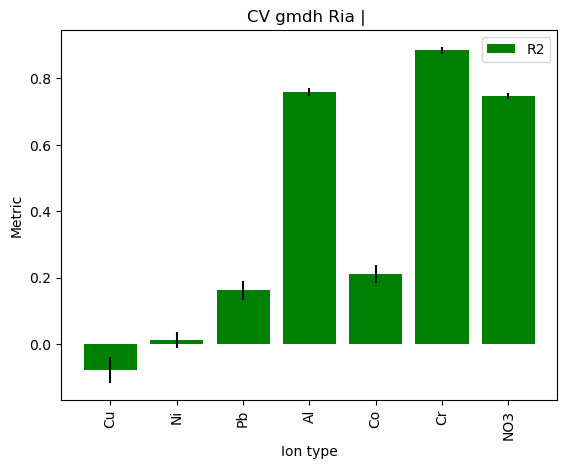

In [41]:
plt.bar(l_PR_ION, gmdh_mean_r2, 
             yerr=gmdh_std_r2, color='g') # , fmt='o-'

#plt.xscale('log')
#plt.yscale('log')
plt.xticks(rotation=90)
plt.xlabel('Ion type') #'number of params'
plt.ylabel('Metric')
plt.legend(['R2'])
plt.title(f'CV gmdh Ria | ')

plt.savefig('Output_data/Multi_Exper_diff_m_gmdh_2.png')

In [42]:
dic = dict(gmdh_mean_rmse = gmdh_mean_rmse,
gmdh_std_rmse = gmdh_std_rmse,
gmdh_mean_mae = gmdh_mean_mae,
gmdh_std_mae = gmdh_std_mae,
gmdh_mean_r2 = gmdh_mean_r2,
gmdh_std_r2 = gmdh_std_r2,
)

df = pd.DataFrame(dic)
df.index = l_PR_ION
df.index.name = 'ion'
df

,gmdh_mean_rmse,gmdh_std_rmse,gmdh_mean_mae,gmdh_std_mae,gmdh_mean_r2,gmdh_std_r2
ion,,,,,,
Cu,2.200802,0.028404,1.805205,0.036690,-0.078189,0.038609
Ni,2.106845,0.041999,1.810302,0.035441,0.012021,0.023188
Pb,1.940320,0.037812,1.645372,0.034375,0.162086,0.028554
Al,1.042723,0.018154,0.795563,0.012430,0.757872,0.011877
Co,1.883040,0.033331,1.583477,0.028684,0.211278,0.026331
Cr,0.718969,0.025831,0.546095,0.018951,0.884640,0.010209
NO3,6.206227,0.141405,4.871938,0.091229,0.747836,0.009031


In [43]:
df.to_csv('Output_data/Multi_Exper_diff_m_gmdh.csv')
df.to_excel('Output_data/Multi_Exper_diff_m_gmdh.xlsx')

# 10. Aggregating all metrics.

In [45]:
df_gmdh = pd.read_csv('Output_data/Multi_Exper_diff_m_gmdh.csv')
df_cb = pd.read_csv('Output_data/Multi_Exper_diff_m_cb.csv')
df_mlp = pd.read_csv('Output_data/Multi_Exper_diff_m_mlp.csv')
df_kan = pd.read_csv('Output_data/Multi_Exper_diff_m_kan.csv')

In [54]:
df_mlp

,ion,cb_mean_rmse,cb_std_rmse,cb_mean_mae,cb_std_mae,cb_mean_r2,cb_std_r2
0,Cu,1.607329,0.035859,1.294553,0.032240,0.424937,0.018455
1,Ni,1.988172,0.025409,1.700716,0.027798,0.119869,0.018773
2,Pb,1.916244,0.042899,1.610981,0.037548,0.183029,0.028345
3,Al,0.848521,0.043643,0.616618,0.026633,0.839095,0.018216
4,Co,1.727316,0.039251,1.431871,0.037887,0.335853,0.030511
5,Cr,0.634105,0.026299,0.469300,0.016541,0.910303,0.008241
6,NO3,5.544705,0.138195,4.383266,0.103638,0.798580,0.011992


In [64]:
l_PR_ION = ['Cu', 'Ni', 'Pb', 'Al', 'Co', 'Cr', 'NO3']

gmdh_mean_rmse, gmdh_std_rmse, gmdh_mean_mae, gmdh_std_mae = df_gmdh.gmdh_mean_rmse, df_gmdh.gmdh_std_rmse, df_gmdh.gmdh_mean_mae, df_gmdh.gmdh_std_mae
cb_mean_rmse, cb_std_rmse, cb_mean_mae, cb_std_mae = df_cb.cb_mean_rmse, df_cb.cb_std_rmse, df_cb.cb_mean_mae, df_cb.cb_std_mae
mlp_mean_rmse, mlp_std_rmse, mlp_mean_mae, mlp_std_mae = df_mlp.cb_mean_rmse, df_mlp.cb_std_rmse, df_mlp.cb_mean_mae, df_mlp.cb_std_mae
kan_mean_rmse, kan_std_rmse, kan_mean_mae, kan_std_mae = df_kan.kan_mean_rmse, df_kan.kan_std_rmse, df_kan.kan_mean_mae, df_kan.kan_std_mae

gmdh_mean_r2, gmdh_std_r2 = df_gmdh.gmdh_mean_r2, df_gmdh.gmdh_std_r2
cb_mean_r2, cb_std_r2 = df_cb.cb_mean_r2, df_cb.cb_std_r2
mlp_mean_r2, mlp_std_r2 = df_mlp.cb_mean_r2, df_mlp.cb_std_r2
kan_mean_r2, kan_std_r2 = df_kan.kan_mean_r2, df_kan.kan_std_r2

Text(0.5, 1.0, '$\\itСАО:     СКО:$')

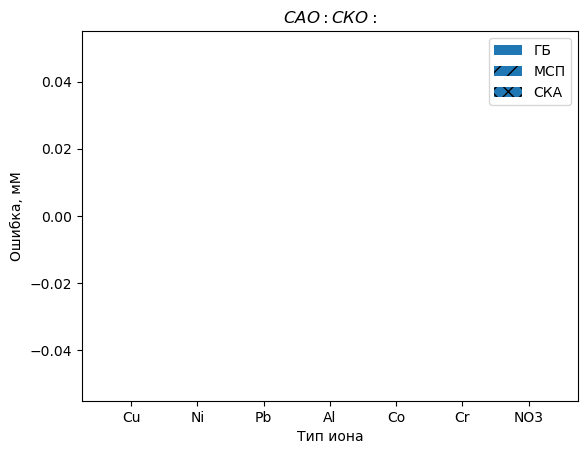

In [25]:
x_axis  = np.arange(len(l_PR_ION))
delta_x = 0.28
width = 0.25
'''
plt.bar(x_axis-delta_x, cb_mean_rmse, 
             yerr=cb_std_rmse,
             width=width, color='C0')  # , fmt='o-'
'''
plt.bar(x_axis-delta_x, cb_mean_mae, 
             yerr=cb_std_mae,
             width=width, color='C0')  # , fmt='o-'

'''
plt.bar(x_axis, mlp_mean_rmse, 
             yerr=mlp_std_rmse,
             width=width, color='C0',
             hatch='//') # , fmt='o-'
'''
plt.bar(x_axis, mlp_mean_mae, 
             yerr=mlp_std_mae,
             width=width, color='C0',
             hatch='//')  # , fmt='o-'
'''
plt.bar(x_axis+delta_x, kan_mean_rmse, 
             yerr=kan_std_rmse,
             width=width, color='C0',
             hatch='xx')  # , fmt='o-'
'''
plt.bar(x_axis+delta_x, kan_mean_mae, 
             yerr=kan_std_mae,
             width=width, color='C0',
             hatch='xx')  # , fmt='o-'


ax = plt.gca()
#ax.set_ylim([0, 20])
#plt.xscale('log')
#plt.yscale('log')

plt.xticks(x_axis, l_PR_ION)
plt.xticks(rotation=0)
plt.xlabel('Тип иона') #'number of params'
plt.ylabel('Ошибка, мМ')
plt.legend(['ГБ', 'МСП', 'СКА'])
plt.title(f'$\it{"САО:     СКО:"}$', fontweight='bold')

#plt.savefig('Output_data/Multi_Exper_diff_m_all_1.png')

Text(0.5, 1.0, 'Comparision of GMDH, CatBoost, MLP and KAN')

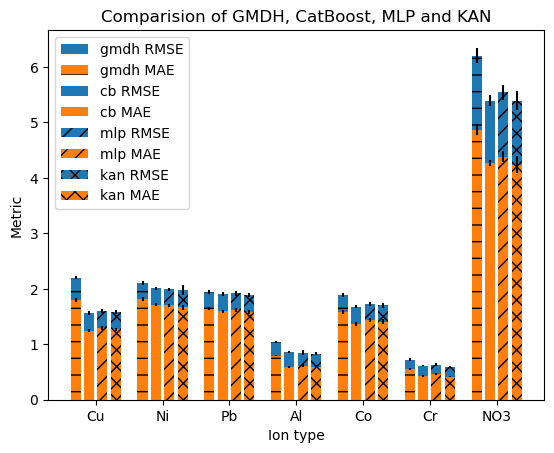

In [63]:
x_axis  = np.arange(len(l_PR_ION))
delta_x = 0.2
width = 0.15

plt.bar(x_axis-1.5*delta_x, gmdh_mean_rmse, 
             yerr=gmdh_std_rmse,
             width=width, color='C0',
             hatch='-')  # , fmt='o-'
plt.bar(x_axis-1.5*delta_x, gmdh_mean_mae, 
             yerr=gmdh_std_mae,
             width=width, color='C1',
             hatch='-')  # , fmt='o-'

plt.bar(x_axis-0.5*delta_x, cb_mean_rmse, 
             yerr=cb_std_rmse,
             width=width, color='C0')  # , fmt='o-'
plt.bar(x_axis-0.5*delta_x, cb_mean_mae, 
             yerr=cb_std_mae,
             width=width, color='C1')  # , fmt='o-'

plt.bar(x_axis+0.5*delta_x, mlp_mean_rmse, 
             yerr=mlp_std_rmse,
             width=width, color='C0',
             hatch='//') # , fmt='o-'
plt.bar(x_axis+0.5*delta_x, mlp_mean_mae, 
             yerr=mlp_std_mae,
             width=width, color='C1',
             hatch='//')  # , fmt='o-'

plt.bar(x_axis+1.5*delta_x, kan_mean_rmse, 
             yerr=kan_std_rmse,
             width=width, color='C0',
             hatch='xx')  # , fmt='o-'
plt.bar(x_axis+1.5*delta_x, kan_mean_mae, 
             yerr=kan_std_mae,
             width=width, color='C1',
             hatch='xx')  # , fmt='o-'


ax = plt.gca()
#ax.set_ylim([0, 20])
#plt.xscale('log')
#plt.yscale('log')

plt.xticks(x_axis, l_PR_ION)
plt.xticks(rotation=0)
plt.xlabel('Ion type') #'number of params'
plt.ylabel('Metric')
plt.legend(['gmdh RMSE', 'gmdh MAE','cb RMSE', 'cb MAE', 'mlp RMSE', 'mlp MAE', 'kan RMSE', 'kan MAE'])
plt.title(f'Comparision of GMDH, CatBoost, MLP and KAN')

#plt.savefig('Output_data/Multi_Exper_diff_m_all_1.png')

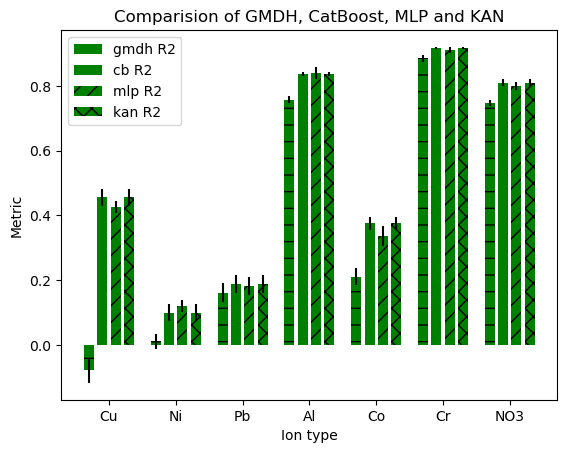

In [67]:
x_axis  = np.arange(len(l_PR_ION))
delta_x = 0.2
width = 0.15

plt.bar(x_axis-1.5*delta_x, np.array(gmdh_mean_r2), 
             yerr=np.array(gmdh_std_r2), width=width, color='g', hatch='-') # , fmt='o-'

plt.bar(x_axis-0.5*delta_x, np.array(cb_mean_r2), 
             yerr=np.array(cb_std_r2), width=width, color='g') # , fmt='o-'

plt.bar(x_axis+0.5*delta_x, np.array(mlp_mean_r2), 
             yerr=np.array(mlp_std_r2), width=width, color='g', hatch='//') # , fmt='o-'

plt.bar(x_axis+1.5*delta_x, np.array(cb_mean_r2), 
             yerr=np.array(cb_std_r2), width=width, color='g', hatch='xx') # , fmt='o-'

plt.xticks(x_axis, l_PR_ION)
#plt.xscale('log')
#plt.yscale('log')
plt.xticks(rotation=0)
plt.xlabel('Ion type') #'number of params'
plt.ylabel('Metric')
plt.legend(['gmdh R2','cb R2', 'mlp R2', 'kan R2'])
plt.title(f'Comparision of GMDH, CatBoost, MLP and KAN')

plt.savefig('Output_data/Multi_Exper_diff_m_all_2.png')

In [68]:
dic = dict(
gmdh_mean_rmse = gmdh_mean_rmse,
gmdh_std_rmse = gmdh_std_rmse,
gmdh_mean_mae = gmdh_mean_mae,
gmdh_std_mae = gmdh_std_mae,
gmdh_mean_r2 = gmdh_mean_r2,
gmdh_std_r2 = gmdh_std_r2, 

mlp_mean_rmse = mlp_mean_rmse,
mlp_std_rmse = mlp_std_rmse,
mlp_mean_mae = mlp_mean_mae,
mlp_std_mae = mlp_std_mae,
mlp_mean_r2 = mlp_mean_r2,
mlp_std_r2 = mlp_std_r2,

cb_mean_rmse = cb_mean_rmse,
cb_std_rmse = cb_std_rmse,
cb_mean_mae = cb_mean_mae,
cb_std_mae = cb_std_mae,
cb_mean_r2 = cb_mean_r2,
cb_std_r2 = cb_std_r2,

kan_mean_rmse = kan_mean_rmse,
kan_std_rmse = kan_std_rmse,
kan_mean_mae = kan_mean_mae,
kan_std_mae = kan_std_mae,
kan_mean_r2 = kan_mean_r2,
kan_std_r2 = kan_std_r2)

In [69]:
df = pd.DataFrame(dic)
df.index = l_PR_ION
df.index.name = 'pred_ion'
df

,gmdh_mean_rmse,gmdh_std_rmse,gmdh_mean_mae,gmdh_std_mae,gmdh_mean_r2,gmdh_std_r2,mlp_mean_rmse,mlp_std_rmse,mlp_mean_mae,mlp_std_mae,mlp_mean_r2,mlp_std_r2,cb_mean_rmse,cb_std_rmse,cb_mean_mae,cb_std_mae,cb_mean_r2,cb_std_r2,kan_mean_rmse,kan_std_rmse,kan_mean_mae,kan_std_mae,kan_mean_r2,kan_std_r2
pred_ion,,,,,,,,,,,,,,,,,,,,,,,,
Cu,2.200802,0.028404,1.805205,0.036690,-0.078189,0.038609,1.607329,0.035859,1.294553,0.032240,0.424937,0.018455,1.563488,0.037424,1.243692,0.025026,0.455670,0.025351,1.584727,0.038165,1.271507,0.028600,0.440750,0.023130
Ni,2.106845,0.041999,1.810302,0.035441,0.012021,0.023188,1.988172,0.025409,1.700716,0.027798,0.119869,0.018773,2.010975,0.030193,1.711031,0.029098,0.100197,0.025298,1.978950,0.085940,1.665439,0.047921,0.127316,0.057479
Pb,1.940320,0.037812,1.645372,0.034375,0.162086,0.028554,1.916244,0.042899,1.610981,0.037548,0.183029,0.028345,1.908046,0.041311,1.592016,0.032530,0.189471,0.028091,1.889123,0.042148,1.579097,0.033550,0.205994,0.025380
Al,1.042723,0.018154,0.795563,0.012430,0.757872,0.011877,0.848521,0.043643,0.616618,0.026633,0.839095,0.018216,0.858601,0.023585,0.597748,0.018519,0.835955,0.006802,0.831016,0.027787,0.596812,0.026057,0.846164,0.010774
Co,1.883040,0.033331,1.583477,0.028684,0.211278,0.026331,1.727316,0.039251,1.431871,0.037887,0.335853,0.030511,1.675312,0.030123,1.368795,0.031942,0.375581,0.019688,1.702345,0.044312,1.402748,0.046184,0.355086,0.033143
Cr,0.718969,0.025831,0.546095,0.018951,0.884640,0.010209,0.634105,0.026299,0.469300,0.016541,0.910303,0.008241,0.611419,0.011794,0.428523,0.013627,0.916834,0.003376,0.589064,0.023416,0.417411,0.012355,0.922614,0.006613
NO3,6.206227,0.141405,4.871938,0.091229,0.747836,0.009031,5.544705,0.138195,4.383266,0.103638,0.798580,0.011992,5.393547,0.094143,4.266689,0.047407,0.809527,0.010173,5.387262,0.171296,4.239517,0.149857,0.809753,0.010482


In [70]:
df.to_csv('Output_data/Multi_Exper_diff_m.csv')
df.to_excel('Output_data/Multi_Exper_diff_m.xlsx')